In [102]:
#CONDA ENV base_conda (python 3.9.7)
#Import packages
#---------------------------------------
import sys
import os
import glob
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
import scanpy as sc
#Import your modules
#---------------------------------------
sys.path.insert(1, '/cndd3/dburrows/CODE/admin_tools/')
from admin_tools import admin_functions as adm

# Define paths
#----------------------------------------------------------------------
l_code = '/Users/dominicburrows/Dropbox/PhD/Analysis/my_scripts/GitHub/'
l_data = '/Users/dominicburrows/Dropbox/PhD/analysis/Project/'
l_fig = '/Users/dominicburrows/Dropbox/PhD/figures/'

s_code = '/cndd3/dburrows/CODE/'
s_data = '/cndd3/dburrows/DATA/'
s_fig = '/cndd3/dburrows/FIGS/'

%load_ext autoreload
sys.version

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:23:11) \n[GCC 9.4.0]'

# Generate pseudobulk mc

In [7]:
#mc
#==============
import ALLCools as ac
path = '/cndd/Public_Datasets/BICCN/BICCN_minibrain_data/data_freeze/snmc_and_snatac/dataset/mc/'
mc_df = pd.read_csv('/cndd/Public_Datasets/BICCN/BICCN_minibrain_data/data_freeze/snmc_and_snatac/study/mc/MOp.snmC-seq.AnalysisResult.csv.gz')

mc_df

,index,FullCellID,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,...,Slice,PassFilter,pca_0,pca_1,umap_0,umap_1,tsne_0,tsne_1,MajorCluster,SubCluster
0,2C_M_0,180508_CEMBA_mm_P56_P63_2C_CEMBA180409_2C_1_CE...,0.00511,0.77073,0.76955,0.02154,0.01651,1076259.0,2314862,1517338.0,...,2,True,-11.588627,-0.005045,10.051389,7.099836,-3.343437,18.330174,L4-IT-Rorb,L4-IT-Rorb_Rorb-Tenm2
1,2C_M_1,180508_CEMBA_mm_P56_P63_2C_CEMBA180409_2C_1_CE...,0.00531,0.75683,0.75553,0.02196,0.01674,1197092.0,2590626,1709334.0,...,2,True,-19.267288,-7.374098,13.717241,-1.786627,9.212860,-26.514785,L23-IT-Cux2,L23-IT-Cux2
2,2C_M_10,180508_CEMBA_mm_P56_P63_2C_CEMBA180409_2C_1_CE...,0.00581,0.75720,0.75578,0.02603,0.02034,1006630.0,2348484,1606410.0,...,2,True,-15.340144,-2.739380,4.829485,9.943986,-22.960995,13.509483,Outlier,Outlier
3,2C_M_100,180508_CEMBA_mm_P56_P63_2C_CEMBA180409_2C_1_CE...,0.00634,0.74984,0.74824,0.02718,0.02097,2026078.0,4599922,3154619.0,...,2,True,-23.625140,-5.929033,13.739521,1.107174,12.798545,-17.126331,L23-IT-Cux2,L23-IT-Cux2
4,2C_M_1000,180508_CEMBA_mm_P56_P63_2C_CEMBA180409_2C_3_CE...,0.00521,0.77073,0.76953,0.02117,0.01604,2368464.0,5320502,3648786.0,...,2,True,-21.815190,-7.130878,14.154541,-2.284118,8.443658,-27.943267,L23-IT-Cux2,L23-IT-Cux2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9871,5D_M_995,180627_CEMBA_mm_P56_P63_5D_CEMBA180605_5D_3_CE...,0.00605,0.80138,0.80017,0.03183,0.02594,800968.0,1767844,1190789.0,...,5,True,-17.305504,0.541289,8.149108,-9.383527,-11.125630,-41.527185,L5-PT-Bcl6,L5-PT-Bcl6
9872,5D_M_996,180627_CEMBA_mm_P56_P63_5D_CEMBA180605_5D_3_CE...,0.00476,0.80081,0.79986,0.02246,0.01778,718290.0,1594474,1064644.0,...,5,True,-11.722283,0.316892,6.512970,6.129021,-10.677095,27.946736,L4-IT-Rorb,L4-IT-Rorb_Rorb-Tenm2
9873,5D_M_997,180627_CEMBA_mm_P56_P63_5D_CEMBA180605_5D_3_CE...,0.00478,0.79146,0.79046,0.02040,0.01570,625473.0,1365894,928844.0,...,5,True,-9.762206,2.836793,6.878475,5.774989,-10.110227,28.544857,L4-IT-Rorb,L4-IT-Rorb_Rorb-Tenm2
9874,5D_M_998,180627_CEMBA_mm_P56_P63_5D_CEMBA180605_5D_3_CE...,0.00571,0.82569,0.82469,0.03079,0.02522,1536923.0,3652902,2506658.0,...,5,True,21.098362,30.776524,23.757244,-7.893738,21.858532,9.493263,L6-CT-Foxp2,L6-CT-Foxp2_Foxp2-Glra2


In [8]:
mc_df.columns

Index(['index', 'FullCellID', 'CCC_Rate', 'CG_Rate', 'CG_RateAdj', 'CH_Rate',
       'CH_RateAdj', 'FinalReads', 'InputReads', 'MappedReads', 'Region',
       'index_name', 'uid', 'BamFilteringRate', 'MappingRate', 'Pos96',
       'Plate', 'Col96', 'Row96', 'Col384', 'Row384', 'FACS_Date', 'Slice',
       'PassFilter', 'pca_0', 'pca_1', 'umap_0', 'umap_1', 'tsne_0', 'tsne_1',
       'MajorCluster', 'SubCluster'],
      dtype='object')

In [261]:
mc_df['Region'].unique()

array(['2C', '3C', '4B', '5D'], dtype=object)

In [10]:
np.unique(mc_df['MajorCluster'], return_counts=True)

(array(['CGE-VipNdnf', 'L23-IT-Cux2', 'L4-IT-Rorb', 'L5-IT-Deptor',
        'L5-PT-Bcl6', 'L6-CT-Foxp2', 'L6-IT-Sulf1', 'L6-NP-Tshz2',
        'L6b-Galnt10', 'MGE-Pvalb', 'MGE-Sst', 'NonN', 'Outlier'],
       dtype=object),
 array([ 625, 2057, 1582,  898,  354, 1622,  881,  275,  141,  460,  471,
         428,   82]))

In [263]:
mc_df['SubCluster'].unique()

array(['L4-IT-Rorb_Rorb-Tenm2', 'L23-IT-Cux2', 'Outlier',
       'CGE-VipNdnf_Lamp5-Unc5d', 'L4-IT-Rorb_Rorb-Ryr3',
       'CGE-VipNdnf_Pex5l', 'L4-IT-Rorb_Rorb-Cpne4',
       'L6-IT-Sulf1_Cables1', 'L5-IT-Deptor', 'NonN_Micro-Csf1r',
       'NonN_Astro-Slc1a2', 'NonN_OPC-Pdgfra', 'NonN_Endo-Nxn',
       'MGE-Sst_Prep', 'L6-CT-Foxp2_Spon1', 'L6-NP-Tshz2',
       'L6-IT-Sulf1_Meis2', 'L6-CT-Foxp2_Foxp2-Glra2', 'MGE-Sst_Daam2',
       'MGE-Sst_Whrn', 'L5-PT-Bcl6', 'CGE-VipNdnf_Vip-Unc5b',
       'CGE-VipNdnf_Vip-Ano4', 'MGE-Pvalb_Man2a1', 'MGE-Sst_Gfra2',
       'MGE-Pvalb_Chrna7', 'CGE-VipNdnf_Vip-Sorcs1',
       'L6-CT-Foxp2_Foxp2-Kcnh5', 'MGE-Pvalb_Cnih3', 'NonN_VLMC-Slc6a13',
       'CGE-VipNdnf_Vip-Prr16', 'CGE-VipNdnf_Lamp5-Ndnf', 'NonN_ODC-Mog',
       'L6-IT-Sulf1_Pcdh15', 'L6-CT-Foxp2_Hcrtr2', 'MGE-Sst_Srrm4',
       'MGE-Sst_Kcnip4', 'NonN_SMC-Myo1b', 'L6-IT-Sulf1_Sulf1',
       'L6-CT-Foxp2_Foxp2-Wscd1', 'MGE-Sst_Chodl', 'MGE-Pvalb_Unc5b',
       'L6b-Galnt10'], dtype=object)

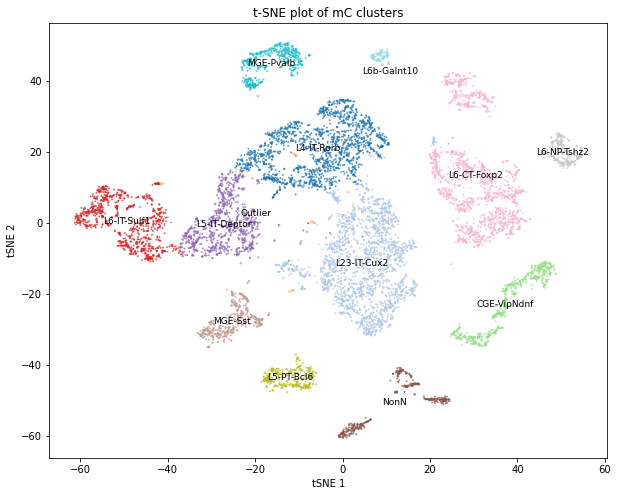

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming atac_df is already loaded as shown in your snippet
prac = mc_df
lab_v = mc_df['MajorCluster'].unique()
store=[]
for p in prac['MajorCluster']:
    ind = np.where(p==lab_v)[0][0]
    store.append(ind)
prac['cluster']=store

# Plot the scatter plot
plt.figure(figsize=(10, 8))  # Optional: Adjust figure size as needed
scatter = plt.scatter(prac['tsne_0'], prac['tsne_1'], s=1, cmap='tab20', c=prac['cluster'], alpha=0.6)

# Calculate centroids and label each cluster
for cluster in prac['cluster'].unique():
    cluster_data = prac[prac['cluster'] == cluster]
    centroid = [cluster_data['tsne_0'].mean(), cluster_data['tsne_1'].mean()]
    # Retrieve the first MajorCluster name associated with this cluster for labeling
    cluster_label = cluster_data['MajorCluster'].iloc[0]
    plt.text(centroid[0], centroid[1], cluster_label, fontsize=9, ha='center', va='center')

plt.xlabel('tSNE 1')  # Adjust label as necessary
plt.ylabel('tSNE 2')  # Adjust label as necessary
plt.title('t-SNE plot of mC clusters')  # Optional: Adjust title as necessary
plt.show()


In [14]:
#Split IDs into GLU and GABA
prac = np.unique(mc_df['MajorCluster'])
prac

array(['CGE-VipNdnf', 'L23-IT-Cux2', 'L4-IT-Rorb', 'L5-IT-Deptor',
       'L5-PT-Bcl6', 'L6-CT-Foxp2', 'L6-IT-Sulf1', 'L6-NP-Tshz2',
       'L6b-Galnt10', 'MGE-Pvalb', 'MGE-Sst', 'NonN', 'Outlier'],
      dtype=object)

In [20]:
mc_df['MajorCluster']

0        L4-IT-Rorb
1       L23-IT-Cux2
2           Outlier
3       L23-IT-Cux2
4       L23-IT-Cux2
           ...     
9871     L5-PT-Bcl6
9872     L4-IT-Rorb
9873     L4-IT-Rorb
9874    L6-CT-Foxp2
9875    L6-CT-Foxp2
Name: MajorCluster, Length: 9876, dtype: object

In [27]:
out = []
for p in mc_df['MajorCluster'].values:
    if 'GE' in p: out.append('GABA')
    elif 'L' in p: out.append('GLU')
    else: out.append('NA')
mc_df['ParentCluster'] = out

In [161]:
#symlink allc data 
arry = glob.glob('/cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/mcds/**')
for a in arry:
    pref= os.path.basename(a)[:2]
    suf=os.path.basename(a).split('.')[0][3:]
    stri=f'/cndd3/Public_Datasets/CEMBA_cndd3/snmCSeq/Datasets/CEMBA_{pref}_{suf}'
    ! ln -s {stri} /cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/


In [171]:
#symlink allc data - separate in GLU + GABA
glu_n = mc_df[mc_df['ParentCluster']=='GLU']['FullCellID'].values
gaba_n = mc_df[mc_df['ParentCluster']=='GABA']['FullCellID'].values

arry = glob.glob('/cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/**')
for a in arry:
    for x in glob.glob(a+'/allc/'+'*bgz'):
        base = x.split('_indexed')[0].split('allc_')[-1]

        if base in gaba_n: 
            ! ln -s {x} /cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/GABA/
            ! ln -s {x+'.tbi'} /cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/GABA/
        if base in glu_n:
            ! ln -s {x} /cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/GLU/
            ! ln -s {x+'.tbi'} /cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/GLU/

In [172]:
#check that names are all there
os.chdir('/cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/GLU')
glu_move = [i.split('_indexed')[0].split('allc_')[-1] for i in glob.glob('*bgz')]
os.chdir('/cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/GABA')
gaba_move = [i.split('_indexed')[0].split('allc_')[-1] for i in glob.glob('*bgz')]
assert sum(np.in1d(gaba_move, gaba_n) !=True) == 0,'some incorrect files have been moved into GABA'
assert sum(np.in1d(glu_move, glu_n) !=True) == 0,'some incorrect files have been moved into GLU'

In [189]:
%%bash
#move file psths into txt file for allcools
find -L /cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/GLU/ -type f -name "*bgz" > /cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/GLU/list.txt


In [177]:
%%bash
outpath=/cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/pseudobulk/coarse/
inpath=/cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/
code_path=/cndd3/dburrows/CODE/deepNN_splice/allcools_merge.sh
# chmod u+x $code_path
# scp $code_path $outpath/log.workspace

cell_arr=("GLU" "GABA")
for c in ${cell_arr[@]}
do
    echo $c
    echo $inpath$c/*.bqz
    
    #$code_path $inpath$c/*.bqz $outpath/$c/
    
done
echo Done


GLU
/cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/GLU/*.bqz
GABA
/cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/GABA/*.bqz
Done


In [179]:
%%bash
outpath=/cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/pseudobulk/coarse/
inpath=/cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/
code_path=/cndd3/dburrows/CODE/deepNN_splice/workspace.py
chmod u+x $code_path
scp $code_path $outpath/log.workspace

cell_arr=("GLU" "GABA")
for c in "${cell_arr[@]}"
do
    echo $c
    bqz_files=$(eval echo $inpath$c/*.bqz)
    echo $bqz_files
#     allcools merge-allc \
#         --cpu 12 \
#         --allc_paths $bqz_files \
#         --output_path $outpath/$c/ \
#         --chrom_size_path /cndd3/dburrows/DATA/annotations/genome/grcm38.p3/modified_mm10.chrom.sizes
done
echo Done


GLU
/cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/GLU/*.bqz
GABA
/cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/GABA/*.bqz
Done


In [100]:
#Run allcools merge to sum over regions across GLU + GABA
%%bash
path=$1
out=$2
allcools merge-allc \
    --cpu 10 \
    --allc_paths $path
    --output_path $out
    --chrom_size_path /cndd3/dburrows/DATA/annotations/genome/grcm38.p3/modified_mm10.chrom.sizes


no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no


In [77]:
#allcools merge -> join celltypes into one allc table
os.chdir('/cndd3/dburrows/DATA/splice/snmcseq-mc_MOp_biccn/allc/CEMBA_2C_180409/allc/')
inp_l = glob.glob('*bgz')

# Generate pseudobulk atac

In [83]:
#atac
#==============
atac_df = pd.read_csv('/cndd/Public_Datasets/BICCN/BICCN_minibrain_data/data_freeze/snmc_and_snatac/study/atac/ATAC.cell_tidy_data.csv.gz', sep=',', index_col=0) 
len(atac_df)

81196

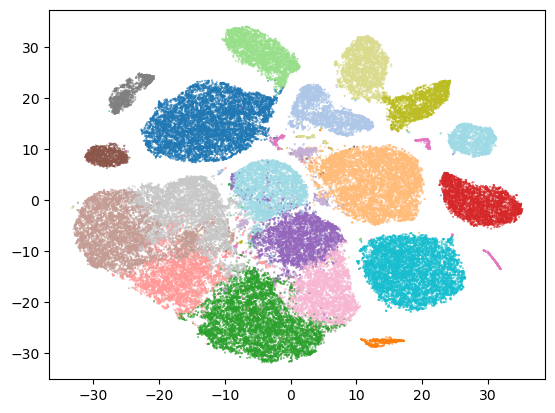

In [81]:
#atac
#==============
atac_df = pd.read_csv('/cndd/Public_Datasets/BICCN/BICCN_minibrain_data/data_freeze/snmc_and_snatac/study/atac/ATAC.cell_tidy_data.csv.gz', sep=',', index_col=0) 
len(atac_df)
prac = atac_df
plt.scatter(prac['tsne_0'], prac['tsne_1'], s=0.1, cmap='tab20', c=prac['cluster'])
plt.show()


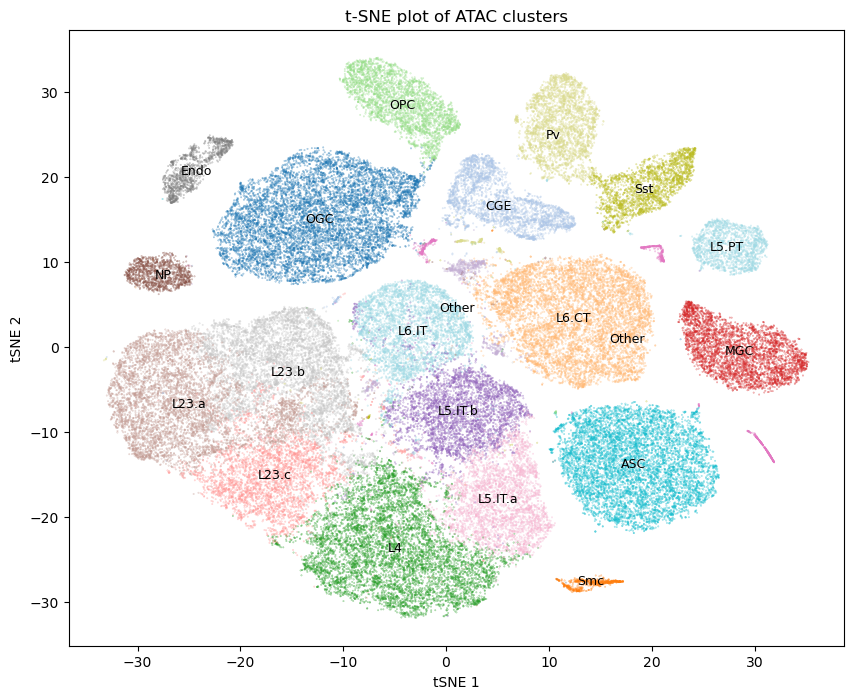

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming atac_df is already loaded as shown in your snippet
prac = atac_df

# Plot the scatter plot
plt.figure(figsize=(10, 8))  # Optional: Adjust figure size as needed
scatter = plt.scatter(prac['tsne_0'], prac['tsne_1'], s=0.1, cmap='tab20', c=prac['cluster'], alpha=0.6)

# Calculate centroids and label each cluster
for cluster in prac['cluster'].unique():
    cluster_data = prac[prac['cluster'] == cluster]
    centroid = [cluster_data['tsne_0'].mean(), cluster_data['tsne_1'].mean()]
    # Retrieve the first MajorCluster name associated with this cluster for labeling
    cluster_label = cluster_data['MajorCluster'].iloc[0]
    plt.text(centroid[0], centroid[1], cluster_label, fontsize=9, ha='center', va='center')

plt.xlabel('tSNE 1')  # Adjust label as necessary
plt.ylabel('tSNE 2')  # Adjust label as necessary
plt.title('t-SNE plot of ATAC clusters')  # Optional: Adjust title as necessary
plt.show()


In [113]:
atac_df['barcode'].unique()

array(['CEMBA171206_3C', 'CEMBA171207_3C', 'CEMBA171212_4B',
       'CEMBA171213_4B', 'CEMBA180104_4B', 'CEMBA180409_2C',
       'CEMBA180410_2C', 'CEMBA180612_5D', 'CEMBA180618_5D'], dtype=object)

In [ ]:
/cndd/Public_Datasets/BICCN/BICCN_minibrain_data/data_freeze/snmc_and_snatac/study/atac/

In [114]:
import h5py
path = '/cndd/Public_Datasets/BICCN/BICCN_minibrain_data/data_freeze/snmc_and_snatac/datasets/atac/'
glob

# Estimate splice junctions from SMARTseq scRNA

In [24]:
#Load metadata from pachter paper
#load in metadata 
meta = sc.read_h5ad('/cndd3/dburrows/DATA/public_datasets/splice//smartseq_mouse_p53-59_MOp_pachter21/metadata/isoform.h5ad')
meta

/home/dburrows/mambaforge/envs/base_conda/lib/python3.9/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/dburrows/mambaforge/envs/base_conda/lib/python3.9/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


AnnData object with n_obs × n_vars = 6160 × 69172
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p', 'norm'
    obsp: 'distances', 'connectivities'

In [51]:
#check that you have all cells
prac = [os.path.basename(i).split('.')[0] for i in glob.glob('/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/fastq/**')]
assert sum(np.in1d(prac, meta.obs['cell_id'].values)) == len(prac), 'some cells in your dir are not in metadata'

In [114]:
#Grab data from nemo
from bs4 import BeautifulSoup

# Specify the path to your HTML file
file_path = '/cndd3/dburrows/DATA/public_datasets/splice/smartseq_mouse_p53-59_MOp_pachter21/nemo.html'

# Open the file and read its contents
with open(file_path, 'r', encoding='utf-8') as file:
    html_content = file.read()

# Parse the HTML content with BeautifulSoup
soup = BeautifulSoup(html_content, 'html.parser')
fastq_links = [a['href'] for a in soup.find_all('a', href=True) if 'fastq' in a['href']]

filt_id = meta.obs['cell_id'].values
raw_id = np.asarray([i.split('.')[0] for i in fastq_links])
if sum(np.in1d(filt_id,raw_id)) == len(filt_id): print('all labelled cells are in nemo archive')

all labelled cells are in nemo archive


In [140]:
#Use filt_id to batch wget files from nemo

#generate txt file with paths
sub_str = 'https://data.nemoarchive.org/biccn/lab/zeng/transcriptome/scell/SSv4/mouse/raw/MOp/'
path_l = [sub_str + i for i in np.asarray(fastq_links)[np.in1d(raw_id, filt_id)]]

file_path = '/cndd3/dburrows/DATA/public_datasets/splice/smartseq_mouse_p53-59_MOp_pachter21/metadata/download_list.txt'

# Writing the URLs to the file
with open(file_path, 'w') as file:
    for url in path_l:
        file.write(url + '\n')
  
# batch download
#! xargs -n 1 -P 10 wget < /cndd3/dburrows/DATA/public_datasets/splice/smartseq_mouse_p53-59_MOp_pachter21/metadata/download_list.txt

In [52]:
np.unique(meta.obs['subclass_label'], return_counts=True)

(array(['Astro', 'Endo', 'L2/3 IT', 'L5 IT', 'L5 PT', 'L5/6 NP', 'L6 CT',
        'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Low Quality', 'Pvalb',
        'SMC', 'Sncg', 'Sst', 'VLMC', 'Vip'], dtype=object),
 array([   9,    7,  482, 1561,   12,  207,  904,  395,    5,  570,  360,
          12,  521,   19,   77,  406,    6,  607]))

In [53]:
np.unique(meta.obs['class_label'], return_counts=True)

(array(['GABAergic', 'Glutamatergic', 'Low Quality', 'Non-Neuronal'],
       dtype=object),
 array([1971, 4136,   12,   41]))

In [58]:
#check that you have all cells
f_l = [os.path.basename(i) for i in glob.glob('/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/fastq/*fastq*')]
meta.obs['cell_id'].values

array(['LS-15395_S47_E1-50', 'LS-15395_S48_E1-50', 'LS-15395_S49_E1-50',
       ..., 'SM-GE935_S382_E1-50', 'SM-GE935_S383_E1-50',
       'SM-GE935_S384_E1-50'], dtype=object)

In [83]:
glu_cell = meta.obs['cell_id'][meta.obs['class_label'] == 'Glutamatergic'].values
gaba_cell = meta.obs['cell_id'][meta.obs['class_label'] == 'GABAergic'].values
cell_l = glu_cell, gaba_cell
name_l = ['GLU', 'GABA']

In [ ]:
# access each file, untar -> append contents of r1 to file and r2 to file
in_path = '/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/fastq/'
out_path = '/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/coarse/'
for y,cell in enumerate(cell_l):
    for x,g in enumerate(cell):
        run = f""" 
        tar -xf {in_path}{g}.fastq.tar --to-stdout {g}_R1.fastq.gz | zcat >> {out_path}{name_l[y]}/{name_l[y]}_R1.fastq
        tar -xf {in_path}{g}.fastq.tar --to-stdout {g}_R2.fastq.gz | zcat >> {out_path}{name_l[y]}/{name_l[y]}_R2.fastq
        """
        
        subprocess.run(run, shell=True)
        if int(x%(len(cell)/10)) == 0: print(f'Done {int(x/len(cell)*100)} ')

In [152]:
# filter reads quality? // trim_galore
%%bash
path=/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/coarse/
#id_arr=($(find $inpath/ -maxdepth 1 -name "*Sample*$str*"))
cell_arr=("GLU" "GABA")
for c in ${cell_arr[@]}
do
    curr=($(ls $path$c))
    echo ${curr[0]}
    echo ${curr[1]}
    trim_galore --cores 10 --paired -q 20 -e 0.1 --fastqc_args "-noextract" $path$c/${curr[0]} $path$c/${curr[1]} -o $path$c
    
done

/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/coarse/GLU_R1.fastq.gz
/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/coarse/GLU_R2.fastq.gz
/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/coarse/GABA_R1.fastq
/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/coarse/GABA_R2.fastq


In [4]:
%%bash
# STAR align// 

path=/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/coarse/
code_path=/cndd3/dburrows/CODE/deepNN_splice/STAR_align.sh
chmod u+x $code_path
scp $code_path $path/log.workspace

cell_arr=("GLU" "GABA")
for c in ${cell_arr[@]}
do
    curr=($(ls $path$c/*val*fq.gz))
    echo ${curr[0]}
    echo ${curr[1]}
    ./$code_path ${curr[0]} ${curr[1]} $path$c/
    samtools index $path$c/Aligned.sortedByCoord.out.bam
    
done
echo Done

/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/coarse/GLU/GLU_R1_val_1.fq.gz
/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/coarse/GLU/GLU_R2_val_2.fq.gz
/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/coarse/GABA/GABA_R1_val_1.fq.gz
/cndd3/dburrows/DATA/splice/smartseq-rna_MOp_biccn/pseudobulk/coarse/GABA/GABA_R2_val_2.fq.gz
Done


In [ ]:
## estimate splice junction usage

# Encode pre-mrna + labels